## Parse IFC file

In [1]:
import re

import ifcopenshell as ifc

In [2]:
bim = ifc.open('../assets/private/histo_v2.ifc')

## List of named spaces

In [3]:
from ifcopenshell import geom as ifc_geom
from ifcopenshell.util import shape as ifc_shape

import pandas as pd

settings = ifc_geom.settings()
settings.set(settings.USE_WORLD_COORDS, True)  # Find global coordinates

def get_area(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    return ifc_shape.get_footprint_area(geom)

def get_centroid(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    x, y, z = ifc_shape.get_bbox_centroid(geom)
    z = ifc_shape.get_shape_bottom_elevation(shape, geom)
    return (x, y)

def get_bottom_elevation(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    z = ifc_shape.get_shape_bottom_elevation(shape, geom)
    return z

spaces = [
    x for x in bim.by_type('IfcSpace') if x.Description is not None
]

data = [
    {
        'id': x.id(),
        'description': re.sub(r'\s+', ' ', x.Description).lower(),
        'area': get_area(x),
        'centroid': get_centroid(x),
        'elevation': get_bottom_elevation(x)
    }
    for x in spaces
]

df = pd.DataFrame(data)
df

,id,description,area,centroid,elevation
0,4446,digital pathology,12.651152,"(87.03472352338409, 56.17319426046846)",7.0
1,4698,cupboard (2),5.490400,"(52.60837679466721, 57.86986107222328)",10.5
2,4722,cupboard (2),3.311260,"(55.09380988963899, 61.26736107222324)",10.5
3,4746,white room cut-up,26.102966,"(69.29587679466721, 63.49391196897473)",10.5
4,4770,cupboard (1),0.883575,"(54.489626794667224, 58.45486107222329)",10.5
5,4866,filing room,14.239375,"(49.868376794667206, 56.221111072223266)",10.5
6,4919,ladies toilet,10.598825,"(56.582126794667204, 63.99736107222324)",10.5
7,4943,ladies toilet,6.074083,"(57.6821267946672, 63.07611107222323)",10.5
8,4967,cupboard (1),0.494019,"(52.83712679466721, 61.74111107222325)",10.5
9,4991,main lab section leaders,16.412656,"(52.932126794667184, 63.54736107222324)",10.5


In [4]:
import matplotlib.pyplot as plt
from histopath_bim_des.bim import BimModel

bim_model = BimModel.from_ifc('../assets/private/histo_v2.ifc')
bim_model.elevations = {k: round(v,5) for k,v in bim_model.elevations.items()}
l3_spaces = df.loc[df.elevation == bim_model.elevations['Level 3 First floor'], :]
l4_spaces = df.loc[df.elevation == bim_model.elevations['Level 4 Second floor'], :]

l3_model = bim_model.to_shapely(level=3)
l4_model = bim_model.to_shapely(level=4)

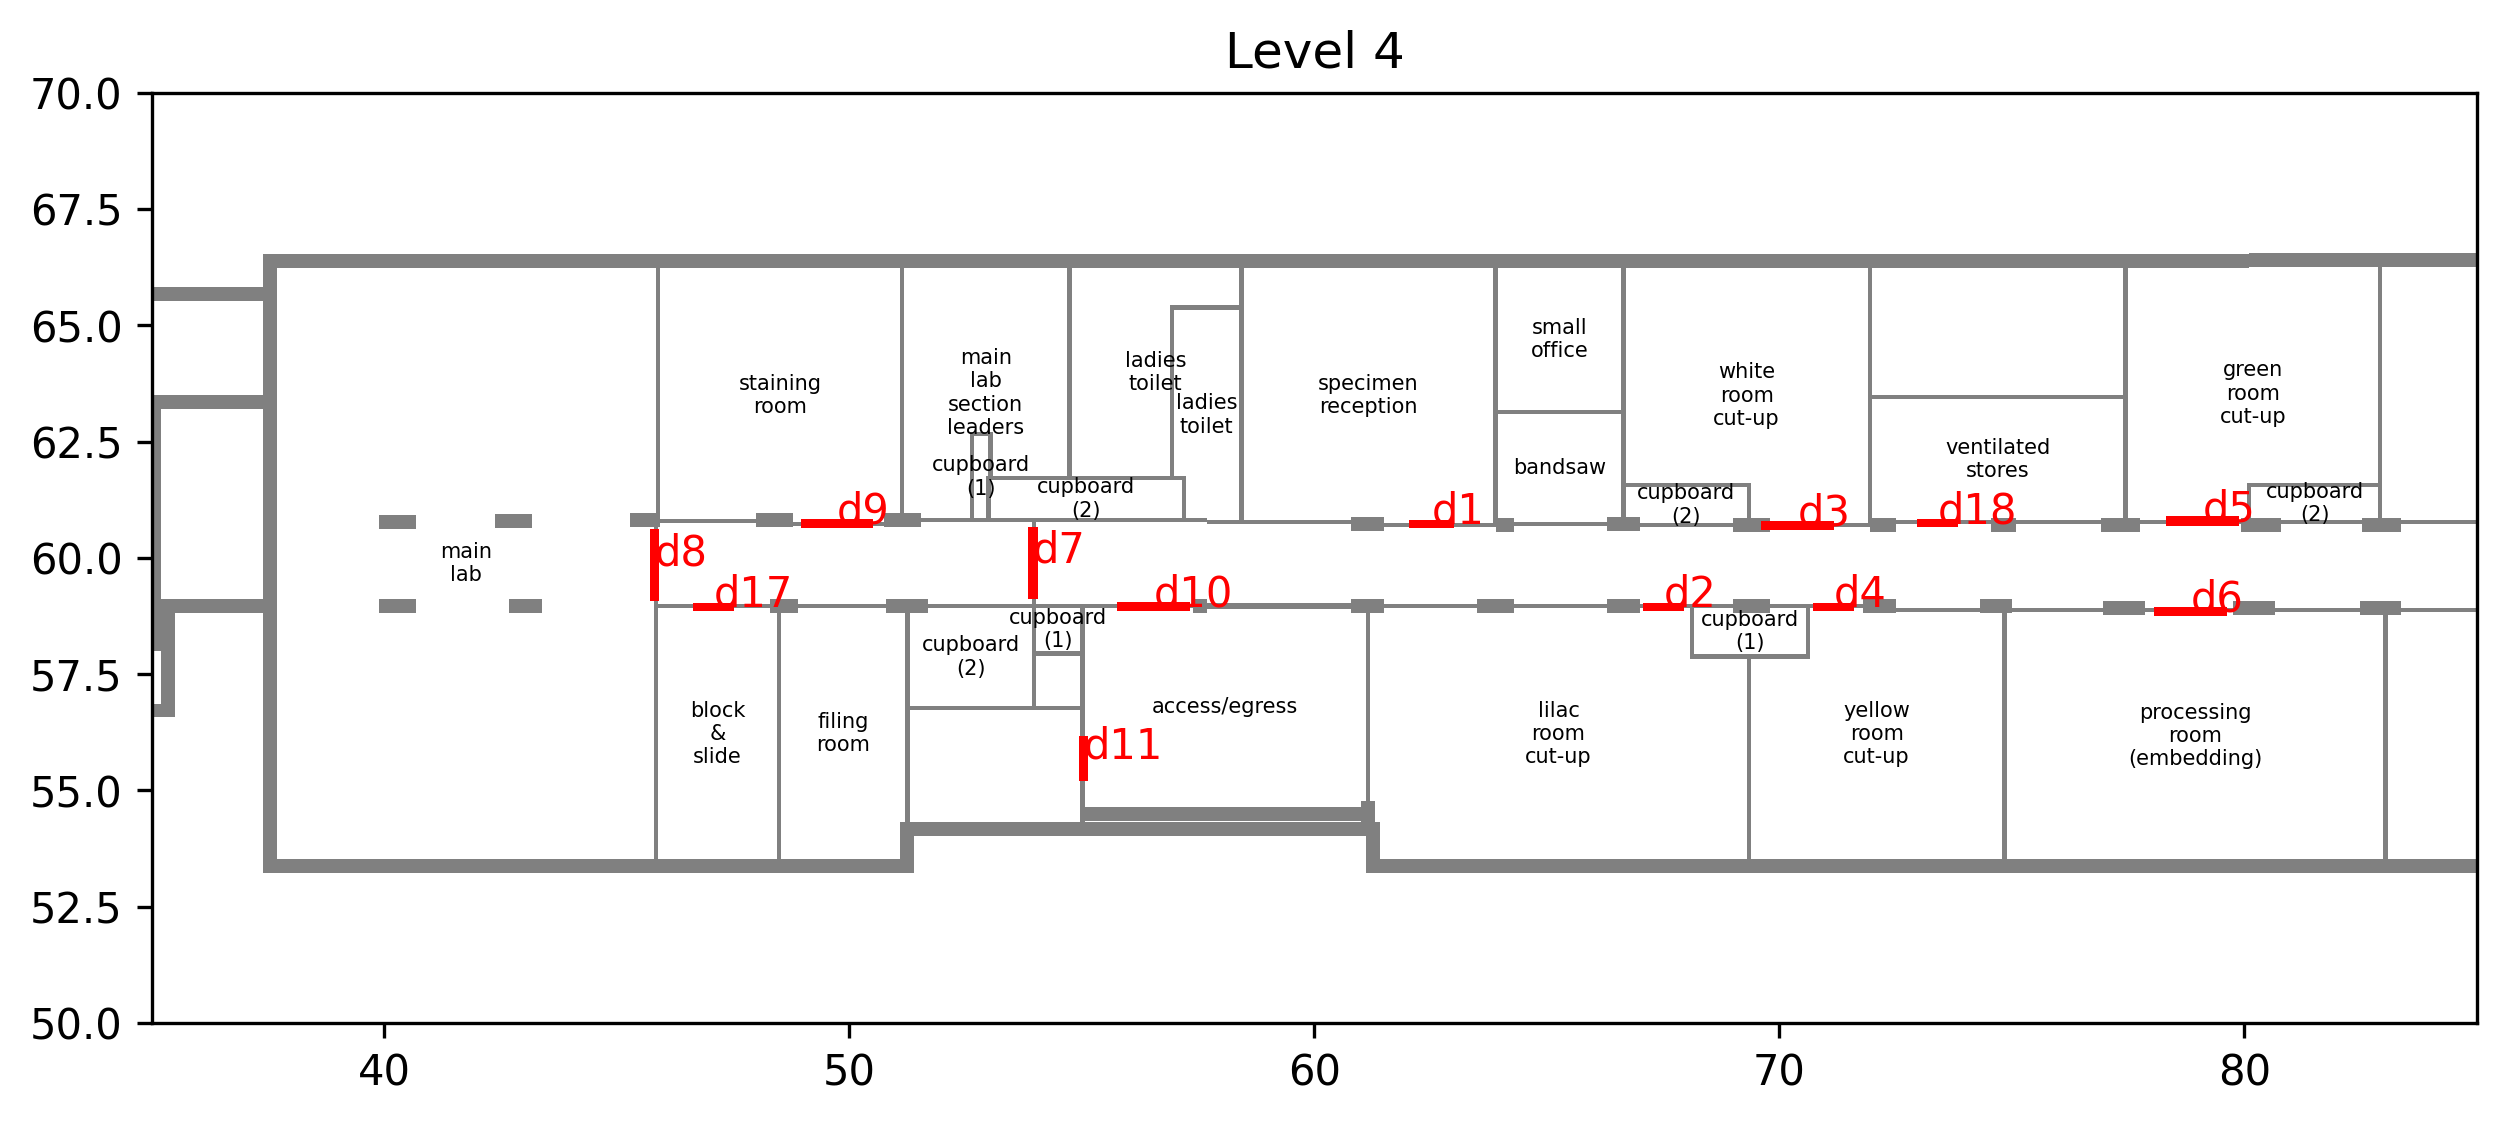

In [5]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax=fig.subplots()
l4_model.plot_floor(ax, 'Level 4', bottom_left=(35,50), top_right=(85,70))

for p, desc in zip(l4_spaces.centroid, l4_spaces.description):
    x, y = p
    ax.annotate(re.sub(r'\s+', '\n', desc),
                (x, y),
                fontsize=5,
                horizontalalignment='center',
                verticalalignment='center')
    

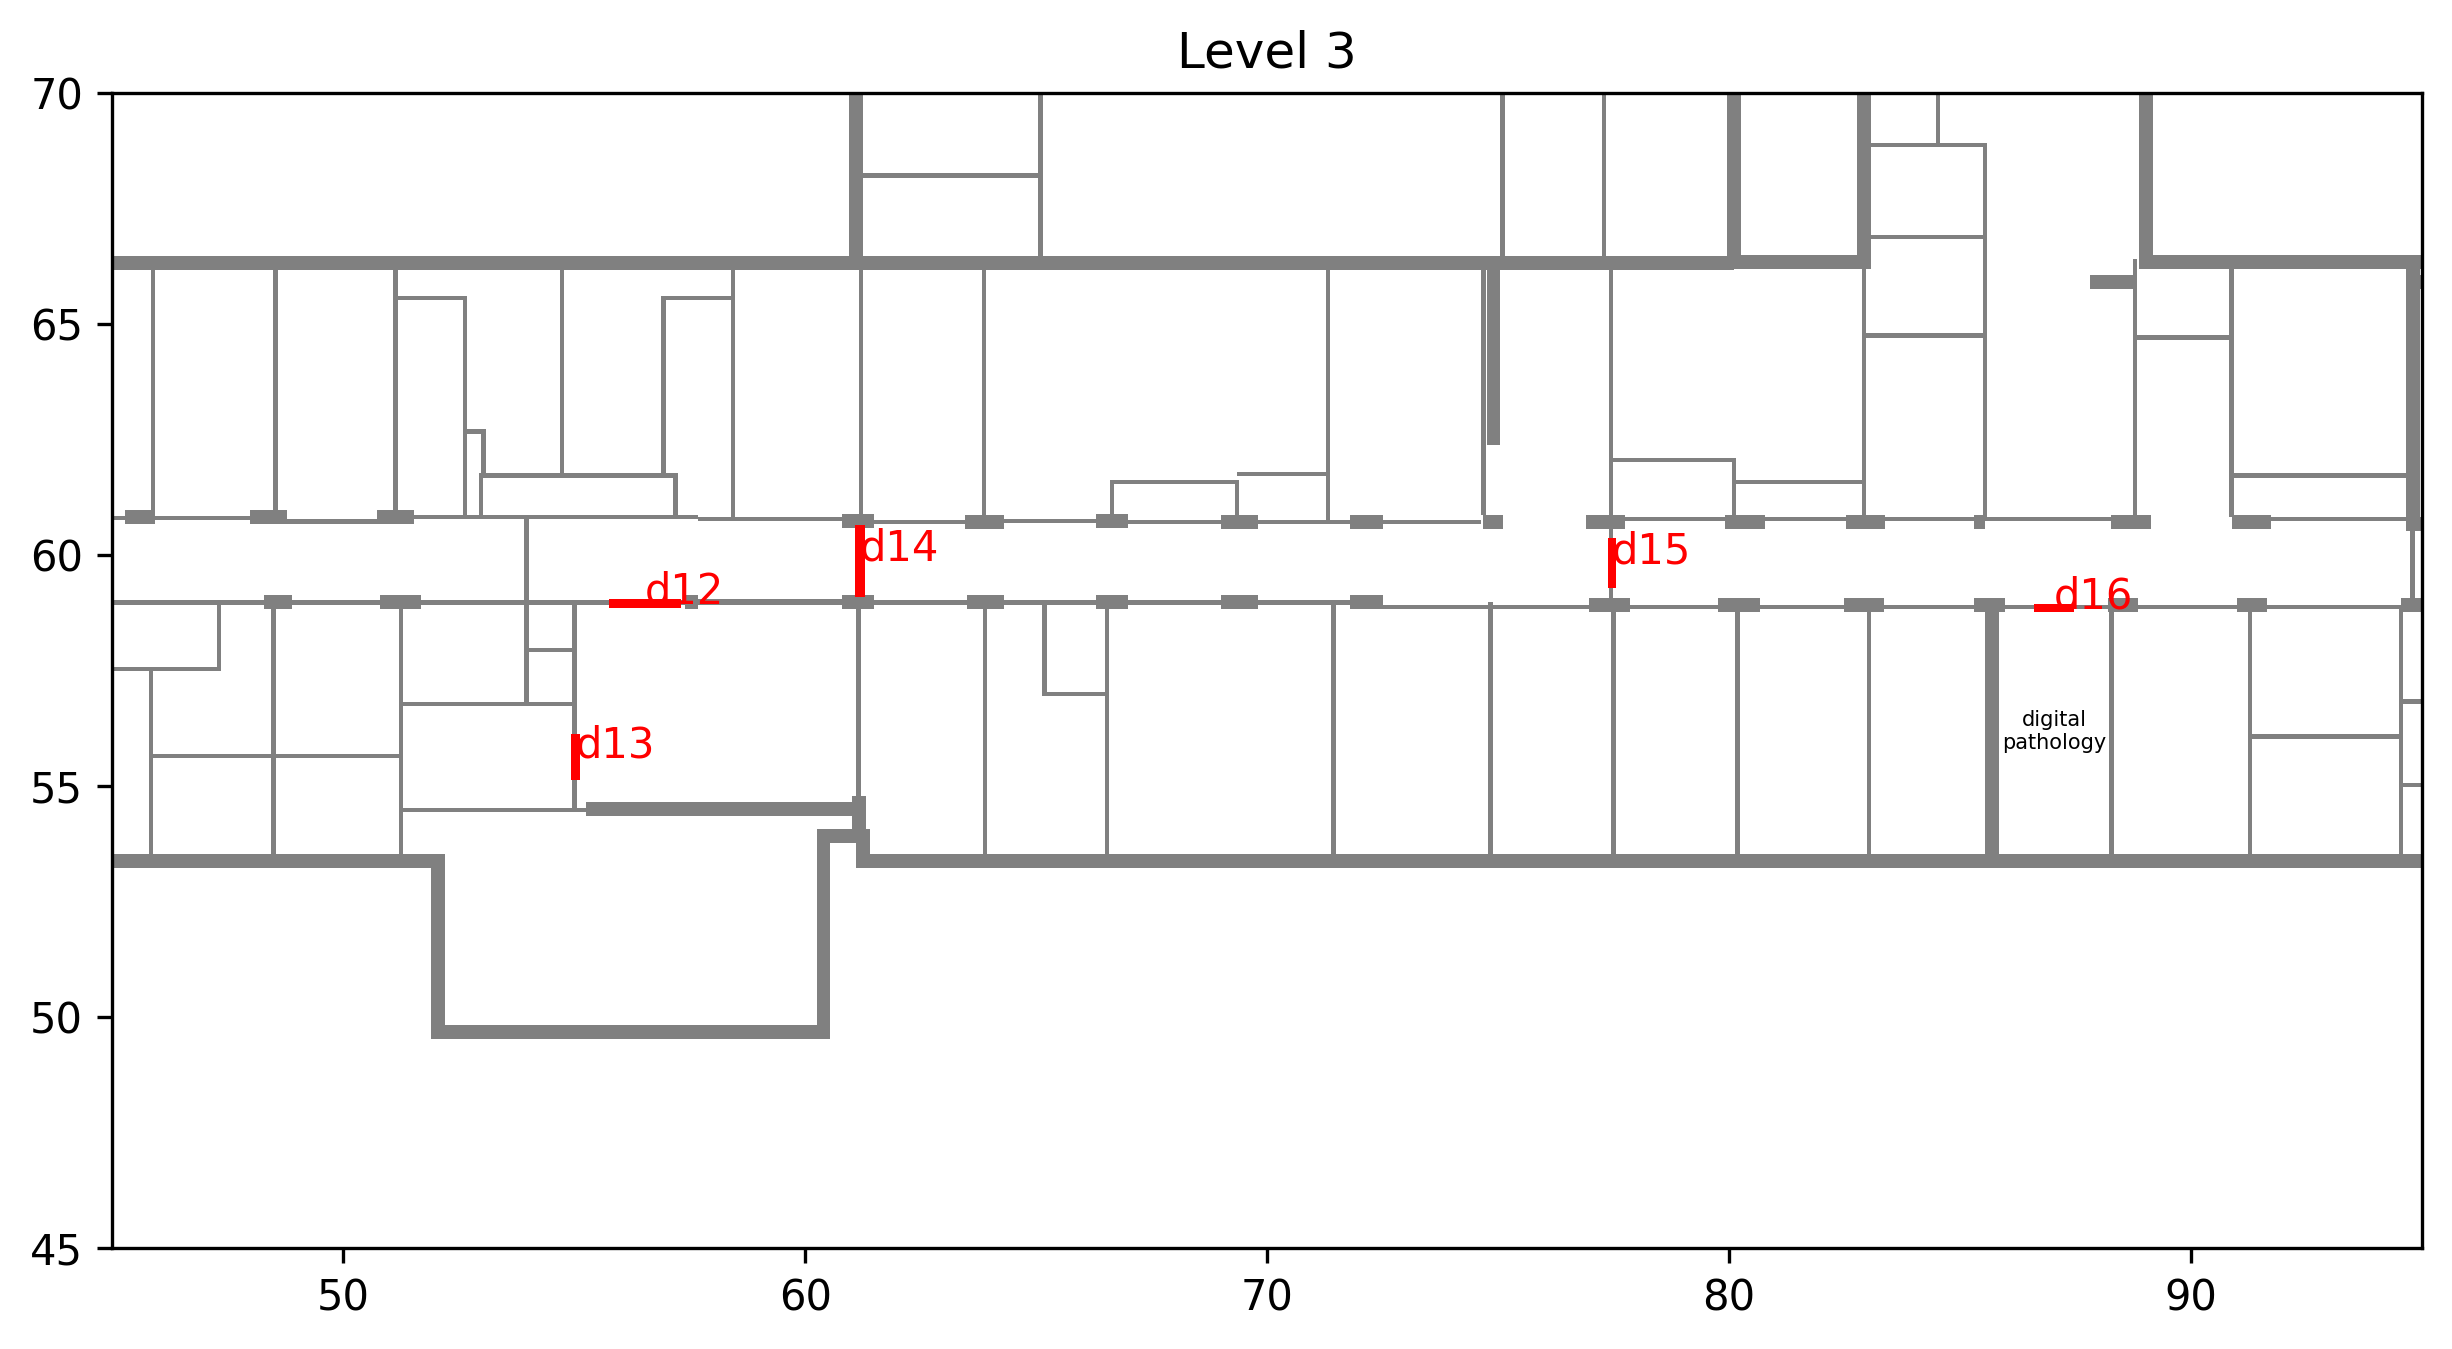

In [6]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax=fig.subplots()
l3_model.plot_floor(ax, 'Level 3', bottom_left=(45,45), top_right=(95,70))

for p, desc in zip(l3_spaces.centroid, l3_spaces.description):
    x, y = p
    ax.annotate(re.sub(r'\s+', '\n', desc),
                (x, y),
                fontsize=5,
                horizontalalignment='center',
                verticalalignment='center')

In [7]:
import networkx as ntx
from histopath_bim_des.config.runners import RunnerConfig
import openpyxl
from histopath_bim_des.bim import logical_graph

runner_cfg_path = '../assets/histo.xlsx'
cfg = RunnerConfig.from_excel(openpyxl.load_workbook(runner_cfg_path, data_only=True))

[[0.25], [0.25], [0.25], [0.25]]


In [8]:
cfg.model_dump()

{'door_map': {'reception': 'd1',
  'cutup': ['d2', 'd3', 'd4', 'd5'],
  'processing': 'd6',
  'microtomy': 'd8',
  'staining': 'd9',
  'labelling': 'd8',
  'scanning': 'd16',
  'qc': 'd8'},
 'runner_speed': 1.2,
 'cutup_dist': [0.25, 0.25, 0.25, 0.25],
 'extra_paths': [{'path': ('d10', 'd12'), 'duration_seconds': 120.0},
  {'path': ('d11', 'd13'), 'duration_seconds': 45.0}],
 'extra_durations': {'loading_time': 15.0, 'unloading_time': 15.0}}

## Logical graph computation

In [9]:
target_levels = [re.match(r'Level (\d+)', s).group(1) for s in bim_model.doors.floor.unique()]
logical_graphs = {level: logical_graph(bim_model.to_shapely(level=level), cfg.runner_speed) for level in target_levels}
full_logical_graph = ntx.compose_all(logical_graphs.values())
for path in cfg.extra_paths: full_logical_graph.add_edge(*path.path, weight=path.duration_seconds)

{('d10', 'd12'): Text(0.3710148401243869, -0.6005288168598493, 'stairs'),
 ('d11', 'd13'): Text(0.904509524863063, -0.293889602215087, 'lift')}

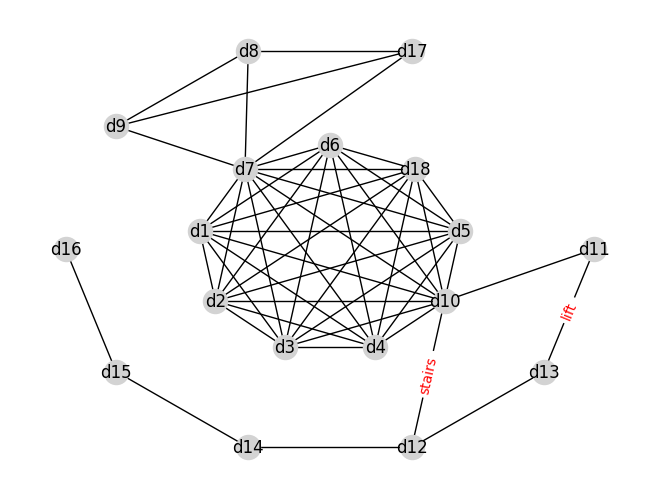

In [10]:
shells = [['d6', 'd7', 'd1', 'd2', 'd3', 'd4', 'd10', 'd5', 'd18'], ['d16', 'd15', 'd14', 'd12', 'd13', 'd11', '', 'd17', 'd8', 'd9']]
positions = ntx.shell_layout(full_logical_graph, shells)
ntx.draw(full_logical_graph, positions, with_labels= True, font_color='black', node_color='lightgray')

ntx.draw_networkx_edge_labels(
    full_logical_graph, positions,
    edge_labels={('d10', 'd12'): 'stairs', 
                 ('d11', 'd13'): 'lift'},
    font_color='red'
)

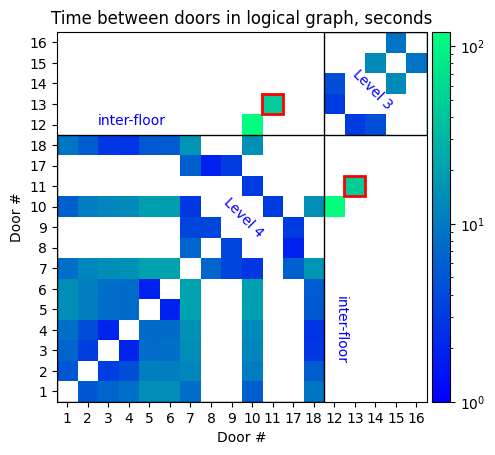

In [11]:
mat = ntx.adjacency_matrix(full_logical_graph).todense()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(mat, interpolation="nearest", origin="lower",
           cmap='winter', norm=LogNorm(vmin=1, vmax=120))
ax.add_patch(Rectangle((-0.5,-0.5), 13, 13, fill=False, edgecolor='k'))
ax.add_patch(Rectangle((12.5,12.5), 5, 5, fill=False, edgecolor='k'))

ax.add_patch(Rectangle((9.5,13.5), 1, 1, fill=False, edgecolor='r', linewidth=2))
ax.add_patch(Rectangle((13.5,9.5), 1, 1, fill=False, edgecolor='r', linewidth=2))

ax.text(1.5,13,'inter-floor', color='b')
ax.text(7.5,7.5,'Level 4', color='b', rotation=-45)
ax.text(13,1.5,'inter-floor', rotation=-90, color='b')
ax.text(13.75,13.75,'Level 3', color='b', rotation=-45)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Door #')
ax.set_ylabel('Door #')
ax.set_title('Time between doors in logical graph, seconds')

nodes = [n[1:] for n in full_logical_graph.nodes]
ax.set_xticks(range(18), nodes)
_ = ax.set_yticks(range(18), nodes)

## Runner times

### Base config

In [12]:
from histopath_bim_des.bim import runner_times


rt = runner_times(bim_model, cfg)
df = pd.DataFrame(
    [[str(k).replace("'",''), v] for k,v in rt.items()],
    columns=['runner_journey', 'runner_time']
)
df

,runner_journey,runner_time
0,"(reception, cutup)",8.452306
1,"(cutup, processing)",6.968697
2,"(processing, microtomy)",28.089256
3,"(microtomy, staining)",3.678511
4,"(staining, labelling)",3.678511
5,"(labelling, scanning)",86.898479
6,"(scanning, qc)",86.898479


### Room-swap scenarios

In [17]:
cfg2 = cfg.copy()
cfg2.door_map.scanning = 'd17'

rt2 = runner_times(bim_model, cfg2)
df2 = pd.DataFrame(
    [[str(k).replace("'",''), v] for k,v in rt2.items()],
    columns=['runner_journey', 'runner_time']
)
df2

,runner_journey,runner_time
0,"(reception, cutup)",8.452306
1,"(cutup, processing)",6.968697
2,"(processing, microtomy)",28.089256
3,"(microtomy, staining)",3.678511
4,"(staining, labelling)",3.678511
5,"(labelling, scanning)",1.839256
6,"(scanning, qc)",1.839256


In [18]:
cfg3 = cfg.copy()
cfg3.door_map.scanning = 'd18'

rt3 = runner_times(bim_model, cfg3)
df3 = pd.DataFrame(
    [[str(k).replace("'",''), v] for k,v in rt3.items()],
    columns=['runner_journey', 'runner_time']
)
df3

,runner_journey,runner_time
0,"(reception, cutup)",8.452306
1,"(cutup, processing)",6.968697
2,"(processing, microtomy)",28.089256
3,"(microtomy, staining)",3.678511
4,"(staining, labelling)",3.678511
5,"(labelling, scanning)",23.261845
6,"(scanning, qc)",23.261845
